In [64]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform, resize
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac

%matplotlib inline


In [43]:
# generate synthetic checkerboard image and add gradient for the later matching
checkerboard = img_as_float(data.checkerboard())
img_orig = np.zeros(list(checkerboard.shape) + [3])
img_orig[..., 0] = checkerboard
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))

img_orig[..., 1] = gradient_r
img_orig[..., 2] = gradient_c
img_orig_gray = rgb2gray(img_orig * 255.0)

img_orig_gray = img_orig_gray.astype(np.uint8)

273 273


C:\Users\faisal\.conda\envs\xray\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


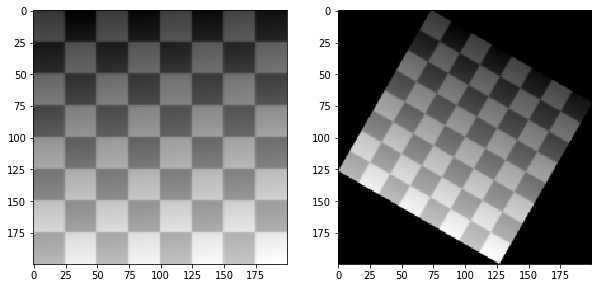

In [66]:
# warp synthetic image
# tform = AffineTransform(rotation=30 *  np.pi/180)
# img_warped = warp(img_orig_gray, tform.inverse, output_shape=(200, 200))
# img_warped_gray = rgb2gray(img_warped)
# Bounded Rotation

(h, w) = img_orig_gray.shape[:2]
(cx, cy) = (w // 2, h // 2)

M = cv2.getRotationMatrix2D((cx, cy), -30, 1.0)
cos = np.abs(M[0, 0])
sin = np.abs(M[0, 1])

nW = int((h * sin) + (w * cos))
nH = int((h * cos) + (w * sin))

M[0, 2] += (nW / 2) - cx
M[1, 2] += (nH / 2) - cy

img_warped_gray = cv2.warpAffine(img_orig_gray, M, (nW, nH))
img_warped_gray = resize(img_warped_gray, (h, w))

f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img_orig_gray, cmap='gray')
ax[1].imshow(img_warped_gray, cmap='gray')
plt.show()


In [77]:
Mt = cv2.getRotationMatrix2D((cx, cy), -30, 1.0)
print (np.arctan2(M[0, 1],  M[0, 0]) * 180.0 / np.pi)

-30.0


In [68]:
# extract corners using Harris' corner measure
coords_orig = corner_peaks(corner_harris(img_orig_gray), threshold_rel=0.001,
                           min_distance=5)
coords_warped = corner_peaks(corner_harris(img_warped_gray),
                             threshold_rel=0.001, min_distance=5)

# determine sub-pixel corner position
coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=9)
coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped,
                                     window_size=9)


def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r, c = np.round(coord).astype(np.intp)
    window_orig = img_orig_gray[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext)
#     weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1]
        print (window_warped.shape)

        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
# print(tform.scale, tform.translation, tform.rotation)
# print(model.scale, model.translation, model.rotation)
# print(model_robust.scale, model_robust.translation, model_robust.rotation)

print (model_robust.rotation * 180/np.pi)

# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences')

plt.show()



(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)


C:\Users\faisal\.conda\envs\xray\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: overflow encountered in longlong_scalars
C:\Users\faisal\.conda\envs\xray\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: overflow encountered in longlong_scalars


ValueError: operands could not be broadcast together with shapes (0,0) (11,11) 